In [8]:
# Dependencies
import pandas as pd
import numpy as np
import requests
import time
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import linregress, ttest_ind

# Load the .csv data file
path = "wildlife_dfm.csv"
animals_df = pd.read_csv(path)

# Drop unnecessary column
animals_df = animals_df.drop("Unnamed: 0", axis='columns')

# Change the name of the Description_x column
animals_df = animals_df.rename(columns={'Description_x': 'WeatherType'})

# Change the name of the Common.Name column
animals_df.rename(columns={'Common.Name': 'animals'}, inplace=True)

# Display first 5 records to ensure proper data load and format
animals_df.head()

,Date,Weathercode,Max Temperature,Min Temperature,Mean Temperature,Sunrise,Sunset,Total Precipitation,Total Rain,Total Snow,...,Species,animals,Species.Diet,Number.of.Animals,Camera.Make,Camera.Model,Flash..Yes.or.No.,Bait.Used,Photos.per.trigger,Description_y
0,2018-05-06,2,69.9,40.4,56.0,06:19:00,20:27:00,0.0,0.0,0.0,...,Sapiens,Human non-staff,Omnivore,1,Bushnell,Agressor,No,None,3,NaN
1,2018-05-06,2,69.9,40.4,56.0,06:19:00,20:27:00,0.0,0.0,0.0,...,Sapiens,Human non-staff,Omnivore,2,Bushnell,Agressor,No,None,3,NaN
2,2018-05-06,2,69.9,40.4,56.0,06:19:00,20:27:00,0.0,0.0,0.0,...,Sapiens,Human non-staff,Omnivore,2,Bushnell,Agressor,No,None,3,NaN
3,2018-05-06,2,69.9,40.4,56.0,06:19:00,20:27:00,0.0,0.0,0.0,...,Lupus Familiaris,Domestic Dog,Carnivore,1,Bushnell,Agressor,No,None,3,NaN
4,2018-05-06,2,69.9,40.4,56.0,06:19:00,20:27:00,0.0,0.0,0.0,...,Sapiens,Human non-staff,Omnivore,2,Bushnell,Agressor,No,None,3,NaN


In [9]:
# Create a list of weather from sunny to heavy snow
weather_conditions = [
    'Sunny', 'Mainly Sunny', 'Partly Cloudy', 'Cloudy',
    'Light Drizzle', 'Drizzle', 'Heavy Drizzle',
    'Light Rain', 'Rain', 'Snow', 'Light Snow', 'Heavy Snow'
]

# Convert list to dataframe
weather_df = pd.DataFrame({
    'Weather Condition': pd.Categorical(weather_conditions, categories=weather_conditions, ordered=True)
})

# Display the DataFrame to check for accuracy
weather_df

,Weather Condition
0,Sunny
1,Mainly Sunny
2,Partly Cloudy
3,Cloudy
4,Light Drizzle
5,Drizzle
6,Heavy Drizzle
7,Light Rain
8,Rain
9,Snow


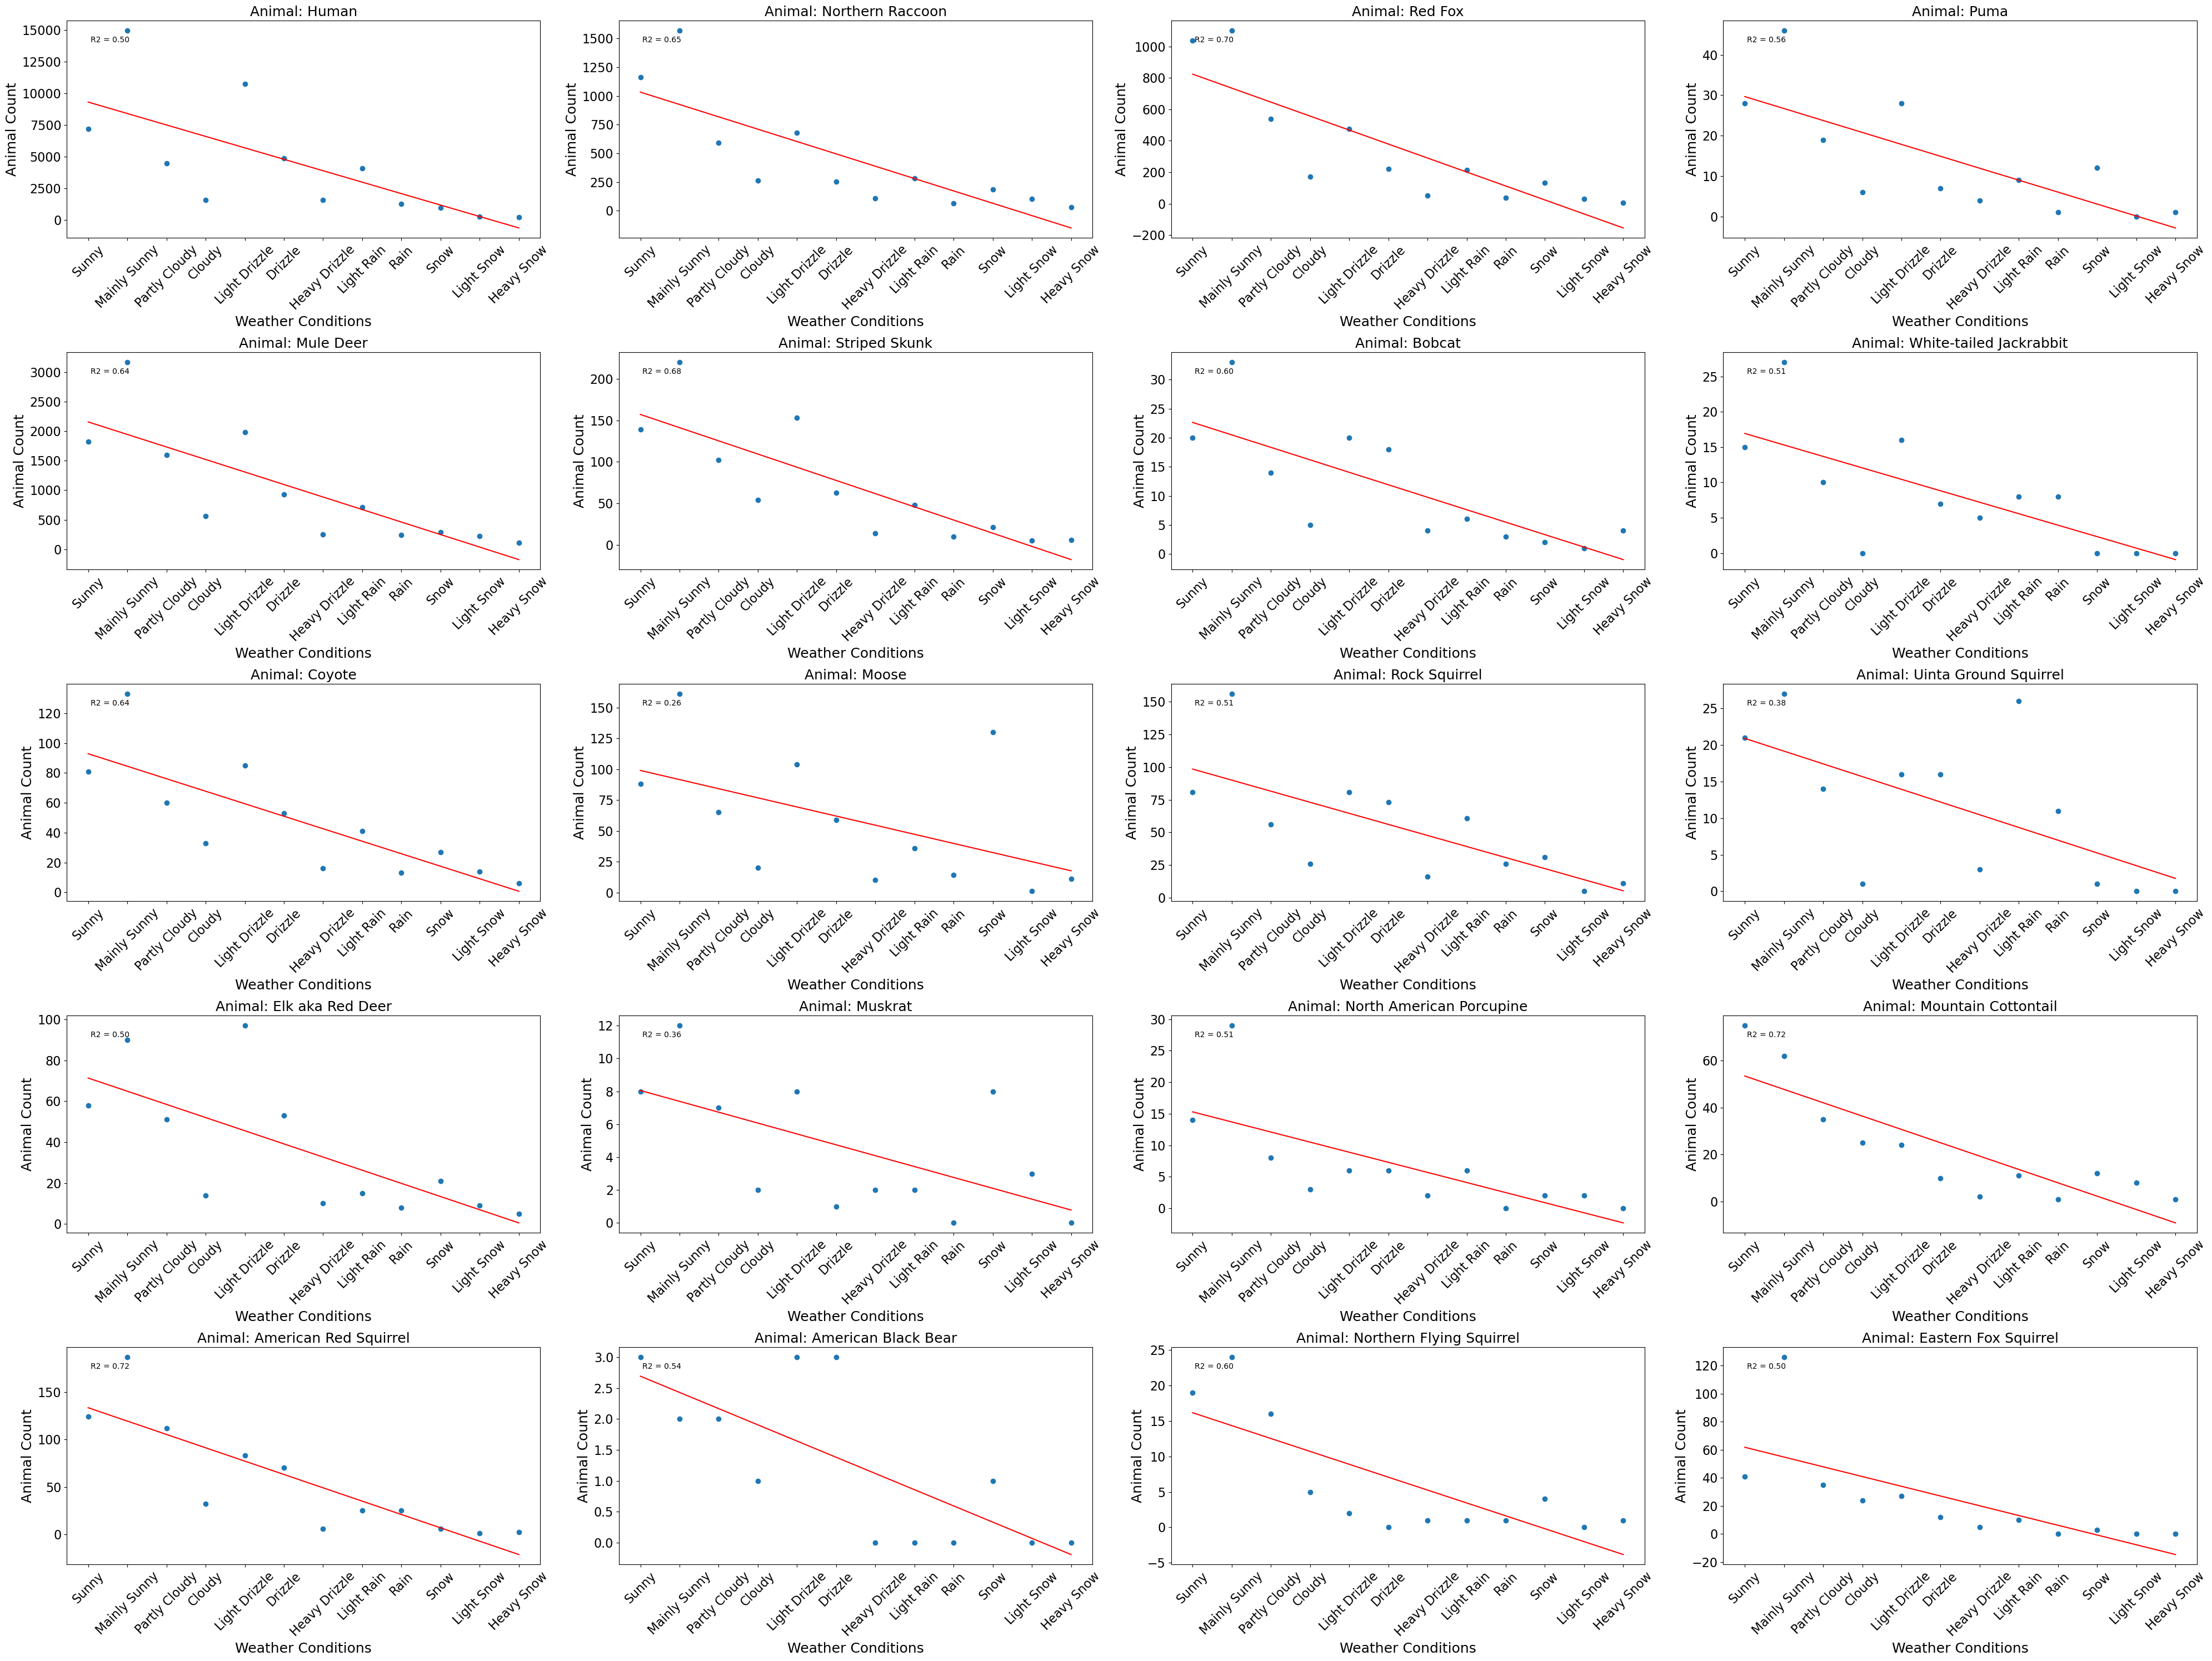

In [12]:
# Replace 'Human non-staff' and 'Bicycle' with 'Human' in 'Common.Name' column of animals_df
animals_df.replace({'animals': {'Human non-staff': 'Human', 'Bicycle': 'Human'}}, inplace=True)

# Exclude specific animals
exclusion = ['Domestic Dog', 'Domestic Cat', 'Domestic Horse', 'Domestic Cow', 'American Beaver', 'American Badger', 'Spotted Skunk', 'Snowshoe Hare', 'Yellow-bellied Marmot', 'Western Spotted Skunk']
animals_df = animals_df[~animals_df['animals'].isin(exclusion)] 

# Group the data by 'Common.Name' and 'WeatherType' and calculate the counts
grouped_data = animals_df.groupby(['animals', 'WeatherType']).size().reset_index(name='count')

# Iterate through each unique animal and create separate scatter plots
unique_animals = animals_df['animals'].unique()

# Set the number of plots per row and column for arranging the subplots
plots_per_row = 4
num_rows = (len(unique_animals) - 1) // plots_per_row + 1

# Set the figure size for each plot
fig_width = 10
fig_height = 6

# Create subplots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(fig_width * plots_per_row, fig_height * num_rows))

# Flatten the axes array in case there is only one row of subplots
axes = axes.ravel()

# Loop through unique animals and create scatter plots with R2 and linear regression lines
for i, animal in enumerate(unique_animals):
    # Filter data for the current animal
    animal_data = grouped_data[grouped_data['animals'] == animal]

    # Fill in missing weather conditions with 0 count to align x-axis for all animals
    animal_data = weather_df.merge(animal_data, left_on='Weather Condition', right_on='WeatherType', how='left').fillna(0)

    # Perform linear regression
    try:
        slope, intercept, r_value, p_value, std_err = linregress(range(len(animal_data)), animal_data['count'])
        r_squared = r_value ** 2
    except ZeroDivisionError:
        slope, intercept, r_squared = 0.0, 0.0, 0.0

    # Create the scatter plot on the respective subplot
    axes[i].scatter(animal_data['Weather Condition'], animal_data['count'])

    # Plot the linear regression line if R2 value is not 0
    if r_squared != 0.0:
        axes[i].plot(animal_data['Weather Condition'], intercept + slope * range(len(animal_data)), color='red', label='Regression Line')

    # Set plot title and labels
    axes[i].set_title(f'Animal: {animal}', fontsize=18)
    axes[i].set_xlabel('Weather Conditions', fontsize=18)
    axes[i].set_ylabel('Animal Count', fontsize=18)
    axes[i].tick_params(labelsize=16)

    # Add R2 value to the plot
    axes[i].text(0.05, 0.9, f'R2 = {r_squared:.2f}', transform=axes[i].transAxes, fontsize=10)

    # Rotate x-axis labels for better visibility
    axes[i].tick_params(axis='x', rotation=45)

# Hide any remaining empty subplots if there are fewer animals than the number of subplots
for j in range(len(unique_animals), num_rows * plots_per_row):
    fig.delaxes(axes[j])

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
# In this changed data set we can see that there is consistency between animal observations decreasing
#as weather conditions worsen. Information from this notebook updated to page 14 of the presentation